https://mondaic.com/docs/0.11.45/references/salvus_mesh_interface/Cartesian3D
    
https://mondaic.com/docs/0.11.45/examples/tutorials/meshing/mesh_quality/tutorial

In [ ]:
#model.description

In [2]:
import sys
#sys.path.append('/exports/csce/datastore/geos/users/s2110831/JUPYTER_old/GRADIOMETRY_Synthetic/Codebase(ii)-REWRITE-04-2021/Functions')
sys.path.append('/scratch/s2110831/JUPYTER/GRADIOMETRY_Synthetic/Codebase_iii_2021/Functions')
sys.path.append('/scratch/s2110831/JUPYTER/GRADIOMETRY_Synthetic/Codebase_iv_2022/Functions_2022')
sys.path.append('/scratch/s2110831/JUPYTER/GRADIOMETRY_Synthetic/Codebase_iii_2021//ViscoELASTIC_2D')
sys.path.append('/exports/csce/datastore/geos/users/s2110831/JUPYTER_old/GRADIOMETRY_Synthetic/Codebase(ii)-REWRITE-04-2021/Functions')
sys.path.append('/exports/csce/datastore/geos/groups/salvus_graddata')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import xarray as xr
import pandas as pd
import json

import salvus
import salvus.namespace as sn
import salvus.mesh.simple_mesh.basic_mesh as mbm
import salvus.flow.simple_config as sc
from salvus.mesh.simple_mesh import rho_from_gardeners, vs_from_poisson

# Specific objects to aid in setting up simulations.
from pyasdf import ASDFDataSet

import h5py
from Forward_run import *
from vel_rho_Q_models import *

# Run simulations on this site.
SALVUS_FLOW_SITE_NAME = os.environ.get("SITE_NAME", "local")

/tmp/ipykernel_2065629/1814604750.py:10: MovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  import salvus.namespace as sn


--> Server: 'https://l.mondaic.com/licensing_server', User: 'marthe.faber', Group: 'UniversityOfEdinburgh'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.40 seconds]


## Parameter Model

There are different ways to define meshes and models in Salvus*Project*. Here we'll define the multi-parameter model as an `xarray` data set which will later be interpolated onto our numerical meshes.

In [5]:
# Grid points of the velocity model.
# NOT the grid point of the simulation!
nx, ny, nz = 600, 600, 300

# Create a coordinate grid.
x = np.linspace(0.0, +600.0-1, nx)
y = np.linspace(0.0, +600.0-1, ny)
z = np.linspace(0.0, +300.0-1, nz)

xx, yy, zz = np.meshgrid(x, y, z, indexing="ij")

In [6]:
# Set minimum velocity
vs0 = 700
vp0 = np.sqrt(3) * vs0
rho0 = 900

# Chose between velocity models (1) "homogeneous" (2) "linear_grad" (3) "het_z" (4) "sin_dist" (5) "het_z_L1xy"
vel_model_type = "heterogeneous_xy_hetZ" #"heterogeneous_xy_hetZ"

# Chose between velocity models (1) "homogeneous" (2) "linear_grad" (3) "het_z" (4) "sin_dist" (5) "heterogeneous_xy"
rho_model_type = 'SAME_STRONGER' #'het_z' #"homogeneous"# "sin_dist2b_hetZ"#"sin_dist2b_hetZ" #"sin_dist2"#"sin_dist2"

vp, vs, rho = build_models_v_rho(vel_model_type, rho_model_type, vp0, vs0, rho0, xx, yy, zz)

In [7]:
#vp = np.reshape(vp,(nx,ny,nz))
#vs = np.reshape(vs,(nx,ny,nz))
#rho = np.reshape(rho,(nx,ny,nz))

In [8]:
#print(vp[2,2,151])
#print(vp[2,2,150])
#print(vp[2,2,149])

In [9]:
#idx_B = 150
#z = np.insert(z, idx_B, 150)
#vp = np.insert(vp, idx_B, np.max(vp),axis=2)
#vs = np.insert(vs, idx_B, np.max(vs),axis=2)
#rho = np.insert(rho, idx_B, np.max(rho),axis=2)

In [10]:
#print(vp[2,2,151])
#print(vp[2,2,150])
#print(vp[2,2,149])

In [11]:
#plt.plot(z,vp[2,2,:])
#plt.xlim([148,152])

In [12]:
rho.shape

(600, 600, 300)

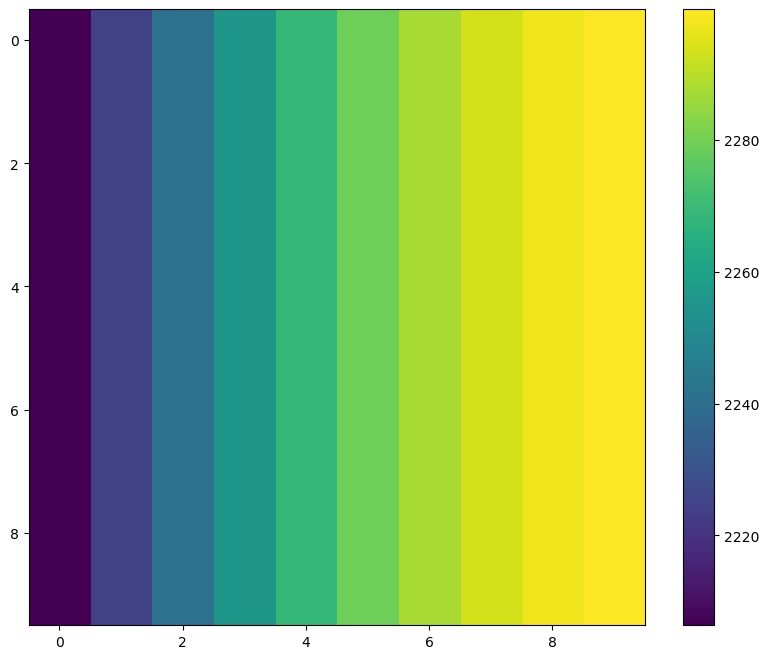

In [13]:

# Assemble into a dataset without Q.
ds_without_q = xr.Dataset(
    data_vars={
        "vp": (["x", "y", "z"], vp),
        #"vs": (["x", "y", "z"], vs),
        "rho": (["x", "y", "z"], rho),
    },
    coords={"x": x, "y": y, "z": z},
)

# Have a look at the vs model.
plt.figure(figsize=(10, 8))
#ds_without_q.rho[298:308,298:308,0].plot()
plt.imshow(ds_without_q.rho[298:308,298:308,-1])#, origin='lower')
plt.colorbar()
plt.show()

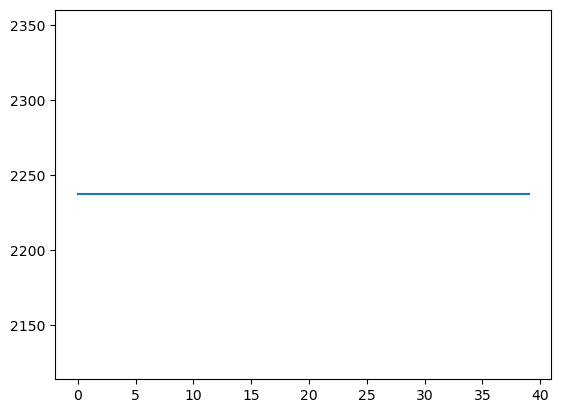

In [14]:
plt.plot(ds_without_q.rho[280:320,5,0])

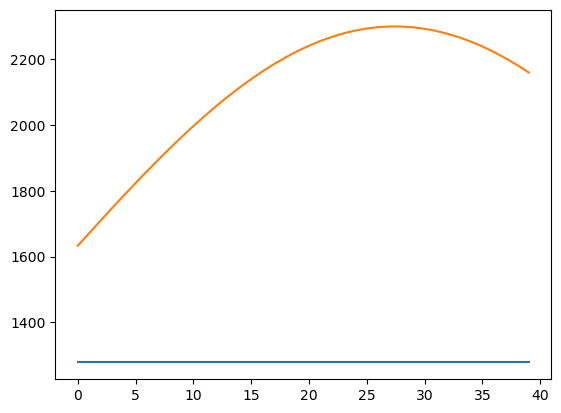

In [15]:
plt.plot(ds_without_q.rho[280:320,5,-1])
plt.plot(ds_without_q.rho[5,280:320,-1])

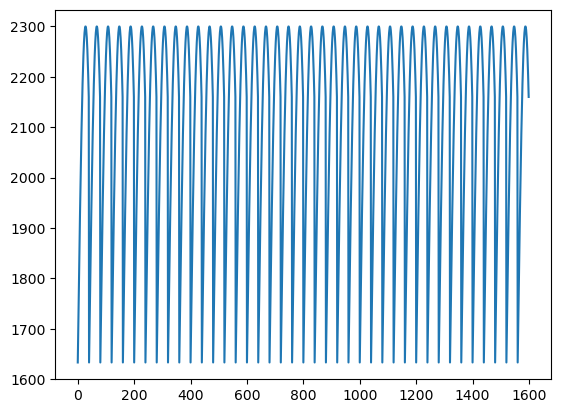

In [16]:
plt.plot(ds_without_q.rho[280:320,280:320,-1].values.flatten())

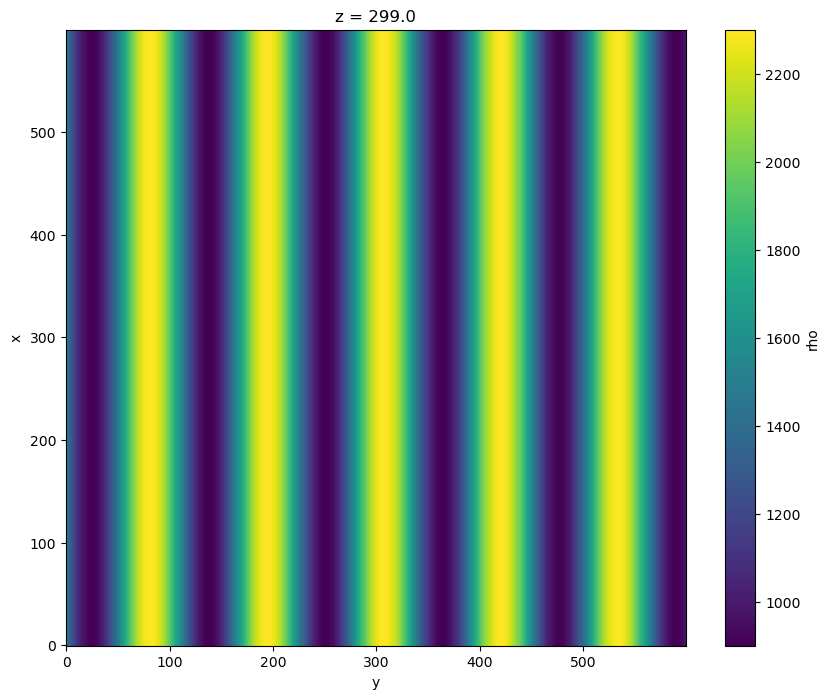

In [17]:
plt.figure(figsize=(10, 8))
ds_without_q.rho[:,:,-1].plot()
plt.show()

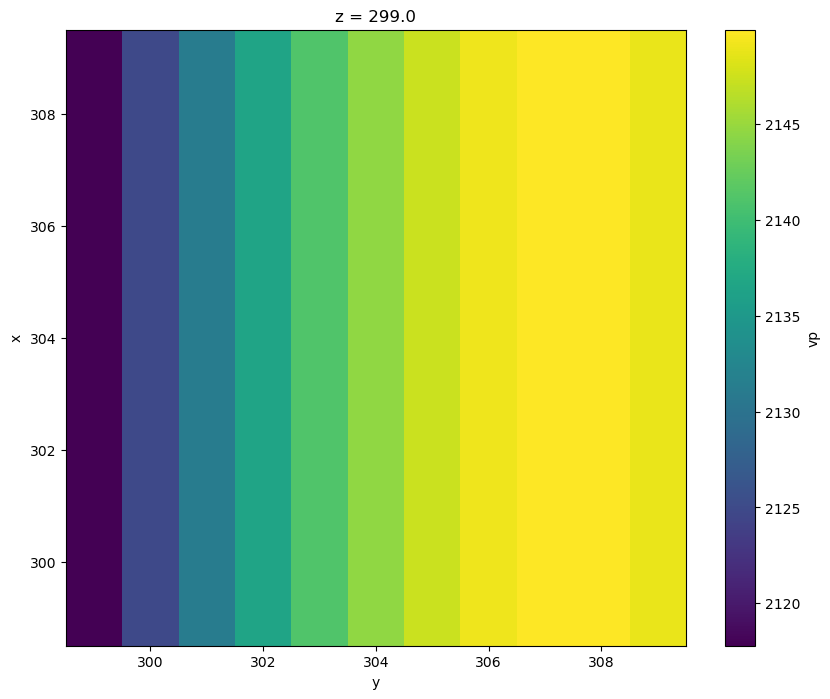

In [18]:
plt.figure(figsize=(10, 8))
#plt.imshow(ds_without_q.vp[299:310,299:310,0].T, origin='lower')
ds_without_q.vp[299:310,299:310,-1].plot()
plt.show()

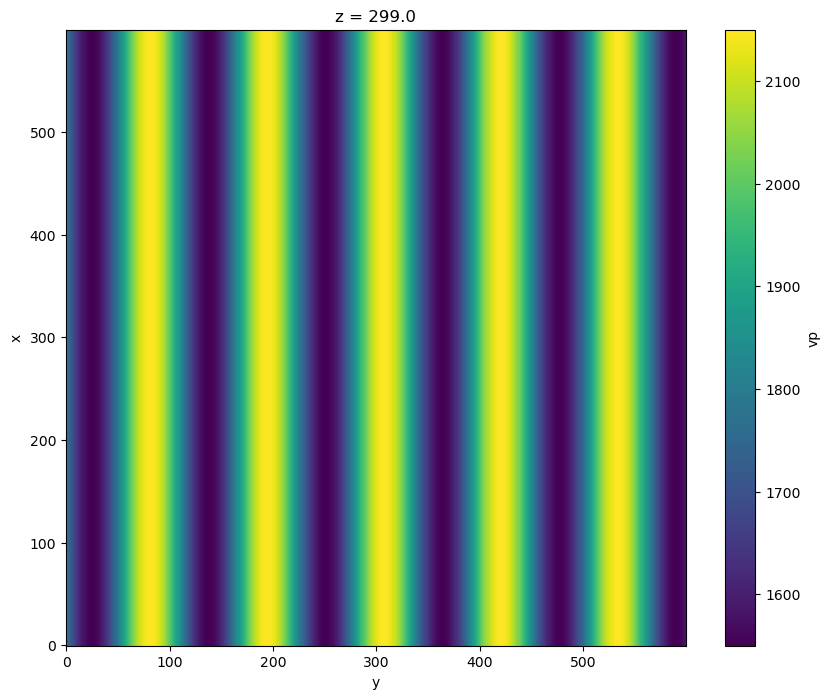

In [19]:
plt.figure(figsize=(10, 8))
ds_without_q.vp[:,:,-1].plot()
plt.show()

In [20]:
np.max(vp)

2712.435565298214

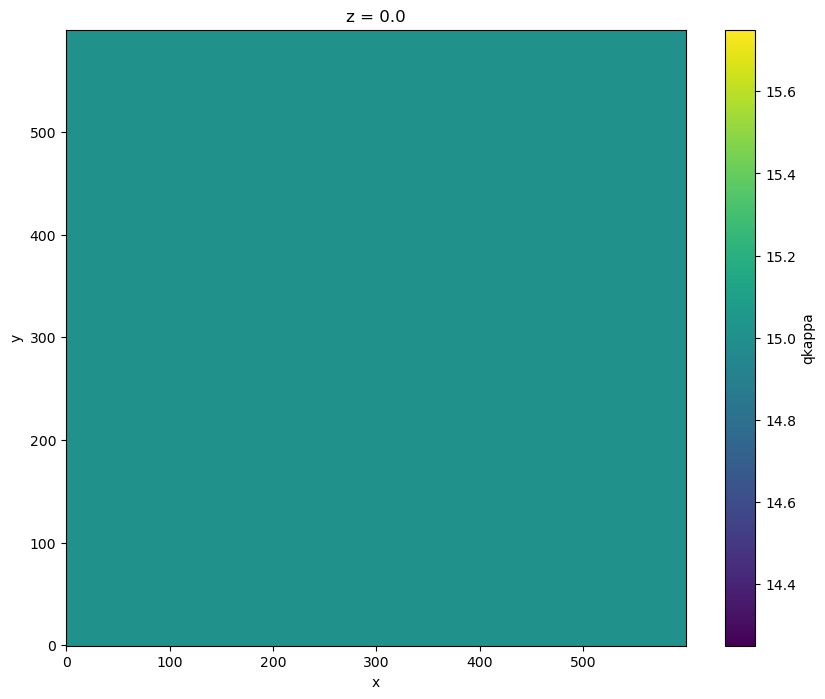

In [21]:
# Chose between attenuation models (1) "homogeneous" (2) "sin_dist" 
Q_model = "homogeneous+"

qmu, qkappa = build_models_Q(Q_model, xx,yy)

ds_with_q = xr.Dataset(
    data_vars={
        "vp": (["x", "y", "z"], vp),
        #"vs": (["x", "y", "z"], vs),
        "rho": (["x", "y", "z"], rho),
        "qkappa": (["x", "y", "z"], qkappa),
        #"qmu": (["x", "y", "z"], qmu),
    },
    coords={"x": x, "y": y, "z": z},
)

# Have a look at the Qmu model.
plt.figure(figsize=(10, 8))
ds_with_q.qkappa[:,:,0].T.plot()
plt.show()

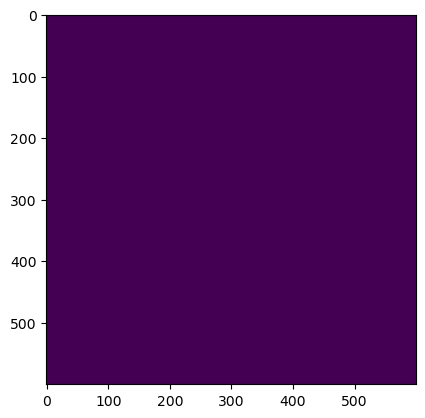

In [22]:
plt.imshow(ds_with_q.qkappa[:,:,0])

In [23]:
f_max = 24#200
elements_per_wavelength = 4#4
vsmin= np.min(vs)
hmax = vsmin / f_max / elements_per_wavelength
print('Element Spacing:', hmax)
hmax

Element Spacing: 9.32180437578956


9.32180437578956

## Create the Project

In [24]:
# Either load an existing project.
#project_name = 'HOMsin600x300_testHETel8'#"HETsin600x300_testHOMdx0.5ambient"# "project3D_grad_0.25dx"#"project3D_homogeneous+"
project_name = '3DACOUSTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-8el_SAME_STRONGER'#fCENT40_taper'#MODEL2'#VISCO_Q8'#40_1mXY'#'3DACOUSTIC_HOM600x300_HOM_ambient16el'
event_name = "src_loc_c_isotropic_FS_src_SURF"

output = '/exports/csce/datastore/geos/users/s2110831/'

if pathlib.Path(str(output)+"out/"+str(project_name)).exists():
    print("Opening existing project.")
    p = sn.Project(path=str(output)+"out/"+str(project_name))
    path_ev = str(output)+"out/"+str(project_name)+"/EVENTS/"+str(event_name)
    #os.mkdir(path_ev)
    fig_ = str(path_ev)+'/FIGURES'
    para_ = str(path_ev)+'/PARAMETERS'
    input_ = str(path_ev)+'/INPUT_MODELS'
    output_ = str(path_ev)+'/OUTPUT_FIELDS'
    _res =  str(fig_)+'/RESULTS'
    
    #os.mkdir(fig_)
    #os.mkdir(para_)
    #os.mkdir(input_)
    #os.mkdir(output_)
    #os.mkdir(_res)
    
# Or create a new one.
else:
    print("Creating new project.")
    p = sn.Project.from_domain(
        path=str(output)+"out/"+str(project_name),
        # Should match the volume model.
        domain=sn.domain.dim3.BoxDomain(x0=-20, x1=nx+20, y0=-20, y1=ny+20, z0=-20, z1=nz),
    )
    path_ev = str(output)+"out/"+str(project_name)+"/EVENTS/"+str(event_name)
    os.mkdir(path_ev)
    fig_ = str(path_ev)+'/FIGURES'
    para_ = str(path_ev)+'/PARAMETERS'
    input_ = str(path_ev)+'/INPUT_MODELS'
    output_ = str(path_ev)+'/OUTPUT_FIELDS'
    _res =  str(fig_)+'/RESULTS'
    data_ = str(output_)+'/DATA'
    
    os.mkdir(fig_)
    os.mkdir(para_)
    os.mkdir(input_)
    os.mkdir(output_)
    os.mkdir(_res)
    os.mkdir(data_)

Opening existing project.


Accordion()



## Simulation Setup

Here we'll create a single explosive source in the center with receivers in a ring around it.

In [25]:
#src = [sn.simple_config.source.cartesian.MomentTensorPoint3D(
#    x=_x, y=_y,z=500, mxx=1.0, myy=1.0, mxy=1.0, mzz=1.0, myz=1.0, mxz=1.0
# for (_x,_y) in zip(loc[:,0], loc[:,1])]
 
#src = [ sn.simple_config.source.cartesian.VectorPoint3D(x=_x, y=_y, z=sz, fx=fx,fy=fy,fz=fz) for (_x,_y) in loc]

In [26]:
source_type = 'ambient_noise1'                  # 'active' or 'ambient_noise'
fx,fy, fz= 1e3,1e3, 1e3                # Source components (Nm)
T = 1/f_max
if source_type == 'ambient_noise1':
    source_depth = nz-nz+(nz-290)#nz-nz+190 #nz-5 #nz-nz+5
    count = 5
    radius = 290
    sx, sy, sz = (nx)/2, (ny)/2, nz -source_depth                  # Source position (m)
#     c_f = np.array([12.0, 4.5, 6.0, 8.0, 16.0, 22.0, 2.5, 1.0, 14.0, 18.0])
#     dl = np.array([1.2, 3.0, 1.6, 1.4, 1.7, 2.0, 2.5, 1.8, 0.6, 1.3])
    c_f = np.array([12.0, 4.5, 6.0, 8.0, 16.0, 22.0, 2.5, 1.0, 14.0, 18.0, 0.2, 0.5, 0.8, 1.5])
    dl = np.array([1.2, 3.0, 1.6, 1.4, 1.7, 2.0, 2.5, 1.8, 0.6, 1.3, 0.8, 1.2, 2.0, 1.6])
    
    phi = np.linspace(-np.pi, np.pi, count, endpoint = False)
    loc = np.array([radius*np.cos(phi) + sx, radius*np.sin(phi) + sy]).T
    src = [ sc.source.cartesian.ScalarPoint3D(x=_x, y=_y, z=sz, f=fx) for (_x,_y) in loc]
    
    stf1 = sc.source.stf.Ricker(center_frequency= float(c_f[0]),time_shift_in_seconds = float(dl[0]*T))
    stf2 = sc.source.stf.Ricker(center_frequency= float(c_f[1]),time_shift_in_seconds = float(dl[1]*T))
    stf3 = sc.source.stf.Ricker(center_frequency= float(c_f[2]),time_shift_in_seconds = float(dl[2]*T))
    stf4 = sc.source.stf.Ricker(center_frequency= float(c_f[3]),time_shift_in_seconds = float(dl[3]*T))
    stf5 = sc.source.stf.Ricker(center_frequency= float(c_f[4]),time_shift_in_seconds = float(dl[4]*T))

    wavelets = [stf1,stf2,stf3,stf4,stf5]#,stf6,stf7,stf8,stf9,stf10]#, stf11, stf12, stf13, stf14]
#     #source-time fct attached later
#     stf1 = sc.source.stf.Ricker(center_frequency= float(c_f[0]),time_shift_in_seconds = float(dl[0]*T))
#     stf2 = sc.source.stf.Ricker(center_frequency= float(c_f[1]),time_shift_in_seconds = float(dl[1]*T))
#     stf3 = sc.source.stf.Ricker(center_frequency= float(c_f[2]),time_shift_in_seconds = float(dl[2]*T))
#     stf4 = sc.source.stf.Ricker(center_frequency= float(c_f[3]),time_shift_in_seconds = float(dl[3]*T))
#     stf5 = sc.source.stf.Ricker(center_frequency= float(c_f[4]),time_shift_in_seconds = float(dl[4]*T))
#     stf6 = sc.source.stf.Ricker(center_frequency= float(c_f[5]),time_shift_in_seconds = float(dl[5]*T))
#     stf7 = sc.source.stf.Ricker(center_frequency= float(c_f[6]),time_shift_in_seconds = float(dl[6]*T)) 
#     stf8 = sc.source.stf.Ricker(center_frequency= float(c_f[7]),time_shift_in_seconds = float(dl[7]*T))
#     stf9 = sc.source.stf.Ricker(center_frequency= float(c_f[8]),time_shift_in_seconds = float(dl[8]*T))
#     stf10 = sc.source.stf.Ricker(center_frequency= float(c_f[9]),time_shift_in_seconds = float(dl[9]*T))
#     #sn.simple_config.stf.Ricker(center_frequency=center_frequency,time_shift_in_seconds = 2*T)
#     wavelets = [stf1,stf2,stf3,stf4,stf5,stf6,stf7,stf8,stf9,stf10]
    center_frequency = np.mean(c_f)
    
elif source_type == 'ambient_noise2':
    count = 8
    radius = 290
    source_depth = nz-nz+(nz-285)#nz-nz+190 #nz-5 #nz-nz+5
    sx, sy, sz = (nx)/2, (ny)/2, nz -source_depth                  # Source position (m)
    c_f = np.array([12.0, 4.5, 6.0, 8.0, 16.0, 22.0, 2.5, 1.0, 14.0, 8.5, 0.2, 0.5, 0.8, 1.5])
    dl = np.array([1.2, 3.0, 1.6, 1.4, 1.7, 2.0, 2.5, 1.8, 0.6, 1.3, 0.8, 1.2, 2.0, 1.6])
    
    phi = np.linspace(-np.pi, np.pi, count, endpoint = False)
    loc = np.array([radius*np.cos(phi) + sx, radius*np.sin(phi) + sy]).T
    src = [ sc.source.cartesian.ScalarPoint3D(x=_x, y=_y, z=sz, f=fx) for (_x,_y) in loc]
    
    stf1 = sc.source.stf.Ricker(center_frequency= float(c_f[6]),time_shift_in_seconds = float(dl[6]*T))
    stf2 = sc.source.stf.Ricker(center_frequency= float(c_f[9]),time_shift_in_seconds = float(dl[9]*T))
    stf3 = sc.source.stf.Ricker(center_frequency= float(c_f[3]),time_shift_in_seconds = float(dl[3]*T))
    stf4 = sc.source.stf.Ricker(center_frequency= float(c_f[13]),time_shift_in_seconds = float(dl[13]*T))
    stf5 = sc.source.stf.Ricker(center_frequency= float(c_f[1]),time_shift_in_seconds = float(dl[1]*T))
    stf6 = sc.source.stf.Ricker(center_frequency= float(c_f[2]),time_shift_in_seconds = float(dl[2]*T))
    stf7 = sc.source.stf.Ricker(center_frequency= float(c_f[8]),time_shift_in_seconds = float(dl[8]*T))
    stf8 = sc.source.stf.Ricker(center_frequency= float(c_f[0]),time_shift_in_seconds = float(dl[0]*T))
    stf9 = sc.source.stf.Ricker(center_frequency= float(c_f[7]),time_shift_in_seconds = float(dl[7]*T))

    wavelets = [stf1,stf2,stf3,stf4,stf5,stf6,stf7,stf8,stf9]#,stf6,stf7,stf8,stf9,stf10]#, stf11, stf12, stf13, stf14]
    center_frequency = np.mean(c_f)

elif source_type == 'active_inline':
    c_f = 12.0
    dl = 2
    source_depth = nz-nz+(nz-290)#nz-nz+190 #nz-5 #nz-nz+5

    sx, sy, sz = 10.0, (ny)/2, nz - source_depth                  # Source position (m)
    src = sc.source.cartesian.VectorPoint3D(x=sx, y=sy,z=sz, fx=fx,fy=fy, fz=fz)

    stf8 = sc.source.stf.Ricker(center_frequency=c_f,time_shift_in_seconds = dl*T)#7
    wavelets = [stf8]
    center_frequency = 12.0
    
elif source_type == 'active_diag':
    c_f = 12.0
    dl = 2
    source_depth = nz-nz+(nz-290)#nz-nz+190 #nz-5 #nz-nz+5

    sx, sy, sz = 10.0,10.0, nz - source_depth                  # Source position (m)
#     src = sc.source.cartesian.VectorPoint3D(x=sx, y=sy,z=sz, fx=fx,fy=fy, fz=fz)
    src = sc.source.cartesian.ScalarPoint3D(x=sx, y=sy,z=sz, f=fx)
    stf8 = sc.source.stf.Ricker(center_frequency=c_f,time_shift_in_seconds = dl*T)
    wavelets = [stf8]
    center_frequency = 12.0

elif source_type == '2z_active':
    dl1 = 3
    dl2 = 2
    c_f = 12
    source_depth = nz-nz+(nz-290)#nz-nz+190 #nz-5 #nz-nz+5

    sx, sy, sz = 10.0,10.0, nz - source_depth                    # Source position (m)
    loc = np.array([sz,source_depth]).T
    src = [ sc.source.cartesian.VectorPoint3D(x=sx, y=sy, z=_z, fx=fx,fy=fy,fz=fz) for (_z) in loc]
    
    stf7 = sc.source.stf.Ricker(center_frequency=c_f,time_shift_in_seconds = dl1*T)
    stf8 = sc.source.stf.Ricker(center_frequency=c_f,time_shift_in_seconds = dl2*T)
    wavelets = [stf7,stf8]
    center_frequency = 12.0

In [27]:
c_f[6]

2.5

In [28]:
src

[{'location': [10.0, 299.99999999999994, 290.0],
  'spatial_type': 'scalar',
  'spatial_weights': [1000.0]},
 {'location': [210.38507163126528, 24.193610274405444, 290.0],
  'spatial_type': 'scalar',
  'spatial_weights': [1000.0]},
 {'location': [534.6149283687348, 129.5422768351828, 290.0],
  'spatial_type': 'scalar',
  'spatial_weights': [1000.0]},
 {'location': [534.6149283687348, 470.4577231648172, 290.0],
  'spatial_type': 'scalar',
  'spatial_weights': [1000.0]},
 {'location': [210.38507163126528, 575.8063897255945, 290.0],
  'spatial_type': 'scalar',
  'spatial_weights': [1000.0]}]

In [29]:
nr = 40#10
n_surf = nr**2
ry0 =  nx/2-39#19.5 47.5#-22.5 #45#4.5#0# -11.5 #-int(11.5/4)   # nx/2 -11.5   # Receiver y-value
ry1 = nx/2 +39#19.5#47.5#+22.5  #45#4.5#9##-2.5 #-int(2.5/4)  # nx/2 -2.5  
rx0 = ny/2 -39#19.5#47.5#-22.5  #45#4.5#0##-11.5 # -int(11.5/4)    #ny/2 -11.5   # x-value of first receiver.
rx1 = ny/2 +39#19.5#47.5#+22.5  #45#4.5#9#-2.5#-int(2.5/4)   #ny/2 -2.5    # x-value of last receiver.
# ry0 =  nx/2 -0# -11.5 #-int(11.5/4)   # nx/2 -11.5   # Receiver y-value
# ry1 = nx/2 +9##-2.5 #-int(2.5/4)  # nx/2 -2.5  
# rx0 = ny/2 -0##-11.5 # -int(11.5/4)    #ny/2 -11.5   # x-value of first receiver.
# rx1 = ny/2 +9#-2.5#-int(2.5/4)   #ny/2 -2.5    # x-value of last receiver.
nrz = 3#101
rz0 = nz      #-20
rz1 = nz-2#-100  #-20
# recs = [
#     sn.simple_config.receiver.cartesian.Point3D(
#     #    x=x, y=y, z=nz, station_code=f"{_i:03d}{_j:03d}", fields=["velocity"]
#     x=x, y=y, z=z ,station_code=f"{_i:02d}{_j:02d}{_k:02d}", fields=["displacement","velocity","gradient-of-displacement","acceleration"]
#     )
#     for _i, x in enumerate(np.linspace(rx0, rx1, nr))
#     for _j, y in enumerate(np.linspace(ry0, ry1, nr))
#     for _k, z in enumerate(np.linspace(rz0, rz1, nrz))
# ]

recs = [
    sn.simple_config.receiver.cartesian.Point3D(
    #    x=x, y=y, z=nz, station_code=f"{_i:03d}{_j:03d}", fields=["velocity"]
    x=x, y=y, z=z ,station_code=f"{_i:02d}{_j:02d}{_k:02d}", fields=["phi_t"]
    )
    for _i, x in enumerate(np.linspace(rx0, rx1, nr))
    for _j, y in enumerate(np.linspace(ry0, ry1, nr))
    for _k, z in enumerate(np.linspace(rz0, rz1, nrz))
]

N_tot = n_surf + nrz

p += sn.Event(event_name=event_name, sources=src, receivers=recs)

p.viz.nb.domain()

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(100,100,100)', 'width': 4},
              'mode': 'lines',
              'name': 'Domain Outline',
              'type': 'scatter3d',
              'uid': '50f2d217-c6fc-4bee-a272-3f5958ce73c5',
              'x': array([-20, 620, 620, -20, -20, -20, 620, 620, -20, -20, 620, 620, 620, 620,
                          -20, -20]),
              'y': array([-20, -20, 620, 620, -20, -20, -20, 620, 620, -20, -20, -20, 620, 620,
                          620, 620]),
              'z': array([-20, -20, -20, -20, -20, 300, 300, 300, 300, 300, 300, -20, -20, 300,
                          300, -20])},
             {'marker': {'color': 'rgb(153, 50, 204)', 'size': 15},
              'mode': 'markers',
              'name': 'Sources',
              'text': [src_loc_c_isotropic_FS_src_SURF source #1,
                       src_loc_c_isotropic_FS_src_SURF source #2,
                       src_loc_c_isotropic_FS_src

Now we'll add both velocity models.

In [30]:
print(recs[0].location)
print(recs[3].location)
#print(recs[101].location)
print(recs[60].location)
#print(recs[1010].location)
dist_X=recs[121].location[0]-recs[0].location[0]
dist_Y=recs[3].location[1]-recs[0].location[1]
# dist_X=recs[1010].location[0]-recs[0].location[0]
# dist_Y=recs[101].location[1]-recs[0].location[1]
#dist_Y=1.0
dist_Z=recs[0].location[2]-recs[1].location[2]
print('Receiver Spacing in X-plane:',dist_X, '[m]')
print('Receiver Spacing in Y-plane:',dist_Y, '[m]')
print('Receiver Spacing in Z-plane:',dist_Z, '[m]')
dist_r = dist_X

[261.0, 261.0, 300.0]
[261.0, 263.0, 300.0]
[261.0, 301.0, 300.0]
Receiver Spacing in X-plane: 2.0 [m]
Receiver Spacing in Y-plane: 2.0 [m]
Receiver Spacing in Z-plane: 1.0 [m]


In [31]:
rec_loc = []
rec_name = []
for i in range(len(recs)):
    rec_loc = np.append(rec_loc,recs[i].location)
    rec_name = np.append(rec_name,str(recs[i].network_code)+'.'+str(recs[i].station_code)+'.')

rec_loc = np.reshape(rec_loc, (len(rec_name),3))    
#rec_loc=rec_loc.tolist()
#rec_name = rec_name.tolist()

receiver_field = xr.Dataset(
    data_vars={
        "location": (["number_stations", "dim"], rec_loc),
        "st_name": (["number_stations"], rec_name),
        
    },
    coords={"number_stations": np.arange(0,len(recs)), 'dim' : ['x','y','z']},
)
rec_list = pd.DataFrame(np.array(receiver_field.location), receiver_field.st_name)
pd.set_option("display.max_rows", None, "display.max_columns", None)
rec_list

,0,1,2
XX.000000.,261.0,261.0,300.0
XX.000001.,261.0,261.0,299.0
XX.000002.,261.0,261.0,298.0
XX.000100.,261.0,263.0,300.0
XX.000101.,261.0,263.0,299.0
XX.000102.,261.0,263.0,298.0
XX.000200.,261.0,265.0,300.0
XX.000201.,261.0,265.0,299.0
XX.000202.,261.0,265.0,298.0
XX.000300.,261.0,267.0,300.0


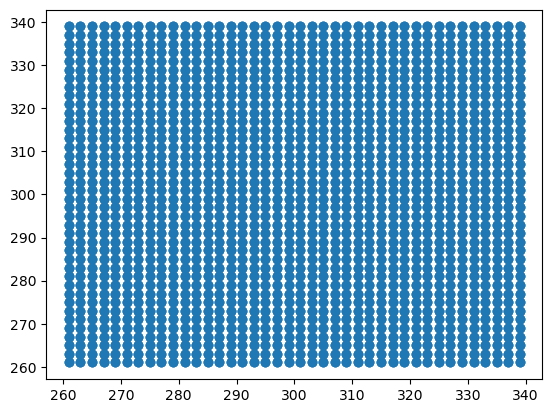

In [32]:
plt.scatter(rec_list[0], rec_list[1])

In [33]:
src

[{'location': [10.0, 299.99999999999994, 290.0],
  'spatial_type': 'scalar',
  'spatial_weights': [1000.0]},
 {'location': [210.38507163126528, 24.193610274405444, 290.0],
  'spatial_type': 'scalar',
  'spatial_weights': [1000.0]},
 {'location': [534.6149283687348, 129.5422768351828, 290.0],
  'spatial_type': 'scalar',
  'spatial_weights': [1000.0]},
 {'location': [534.6149283687348, 470.4577231648172, 290.0],
  'spatial_type': 'scalar',
  'spatial_weights': [1000.0]},
 {'location': [210.38507163126528, 575.8063897255945, 290.0],
  'spatial_type': 'scalar',
  'spatial_weights': [1000.0]}]

In [38]:
p += sn.model.volume.cartesian.GenericModel(
    name="model_without_Q", data=ds_without_q
)

p += sn.model.volume.cartesian.GenericModel(
    name="model_with_Q", data=ds_with_q)

#p.__dict__

In [39]:
# A few wave-lengths are needed to see an attenuating effect.
#center_frequency = 10.0
sim_time = 3.0 #s
# Set-up two simulations: One with attenuation, one without.
for attenuation in [True, False]:
    if attenuation:
        simulation_name = "with_attenuation"
        mc = sn.ModelConfiguration(
            background_model=None,
            volume_models="model_with_Q",
            # Attenuation results in slightly frequency dependent wave speed.
            # Thus one must specify at what frequency they are specified.
            # They are often given at 1 Hz.
            linear_solids=sn.LinearSolids(reference_frequency=1.0),
        )
    else:
        simulation_name = "without_attenuation"
        mc = sn.ModelConfiguration(
            background_model=None, volume_models="model_without_Q"
        )
    
    p += sn.SimulationConfiguration(
    name=simulation_name,
    max_frequency_in_hertz= 2*np.max(c_f[0:5]),#24,#2*np.max(c_f[0:5]),#24,#2*np.max(c_f[6:10]),#center_frequency * 2.0,# np.max(c_f[0:5])*2,#center_frequency * 2.0,#np.max(c_f[0:5])*2, #f_max, #center_frequency * 2.0,
    tensor_order = 1,
    elements_per_wavelength=8.0,
    model_configuration=mc,
    absorbing_boundaries = mbm.AbsorbingBoundaryParameters(reference_velocity=np.min(vs), free_surface = True,
                                                    number_of_wavelengths=1.5, reference_frequency=center_frequency * 3.0),#16#(center_frequency * 2.0)
    ##absorbing_boundaries = mbm.AbsorbingBoundaryParameters(reference_velocity=np.min(vs), free_surface = False,
    ##                                                number_of_wavelengths=1.5, reference_frequency=(center_frequency * 2.0)+1),
    event_configuration=sn.EventConfiguration(
    wavelet= wavelets,      #[0]
    waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
    end_time_in_seconds=sim_time,
    time_step_in_seconds =  0.00013683608340735724,
    #time_step_in_seconds = 0.0001,#0.00033912678552380765# 0.0001,# 2.115205e-04,#0.00023171707720226795/3, #/5,
    # This is to tell the simulation to actually
    # simulate with attenuation or not.
    attenuation=attenuation
                ),
            ), 
        )

#p.viz.nb.simulation_setup("with_attenuation")

# attach side sets
# extract BC conditions
# figure out how to attach multiple sources...
# extract mesh elements etc
# save 3d model images?? even if it is just a screenshot

In [40]:
event_configuration=sn.EventConfiguration(
    wavelet= wavelets,      #[0]
    waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
    end_time_in_seconds=sim_time,
    #time_step_in_seconds = 0.0001,#0.00033912678552380765# 0.0001,# 2.115205e-04,#0.00023171707720226795/3, #/5,
    # This is to tell the simulation to actually
    # simulate with attenuation or not.
    attenuation=attenuation
                ),
            )

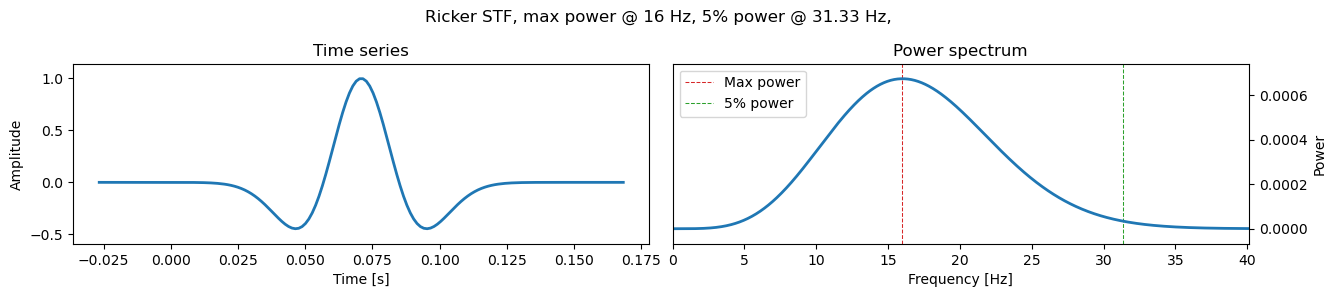

In [41]:
event_configuration.wavelet[4].plot()

In [42]:
2*np.max(c_f[0:5])

32.0

In [43]:
center_frequency * 2.0

15.285714285714286

In [44]:
f_max

24

In [45]:
# elements_per_wavelength = 8#4
# vsmin= np.min(vs)
# hmax = vsmin / (np.max(c_f[0:5])*2) / elements_per_wavelength
# print('Element Spacing:', hmax)
# hmax

In [46]:
center_frequency 

7.642857142857143

In [47]:
#p.simulations.get_mesh("with_attenuation").define_side_set.func_doc

In [48]:
[w for w in zip(wavelets)][:]

[({'center_frequency': 12.0,
   'time_shift_in_seconds': 0.049999999999999996,
   'wavelet': 'ricker'},),
 ({'center_frequency': 4.5, 'time_shift_in_seconds': 0.125, 'wavelet': 'ricker'},),
 ({'center_frequency': 6.0,
   'time_shift_in_seconds': 0.06666666666666667,
   'wavelet': 'ricker'},),
 ({'center_frequency': 8.0,
   'time_shift_in_seconds': 0.05833333333333333,
   'wavelet': 'ricker'},),
 ({'center_frequency': 16.0,
   'time_shift_in_seconds': 0.07083333333333333,
   'wavelet': 'ricker'},)]

In [49]:
mesh = p.viz.nb.simulation_setup("without_attenuation")
#mesh

[2023-12-05 09:23:55,354] INFO: Creating mesh. Hang on.


In [50]:
mesh

In [51]:
mesh.elemental_fields['fluid']= np.ones(mesh.elemental_fields['fluid'].shape)

In [52]:
mesh.elemental_fields['fluid']

array([1., 1., 1., ..., 1., 1., 1.])

In [53]:
#stopp#mesh

In [54]:
#mesh.compute_dt(np.max(ds_without_q.vp.values), 0.1)

In [55]:
from salvus.mesh.unstructured_mesh_utils import extract_model_to_regular_grid

In [56]:
#ds_extract_3d = extract_model_to_regular_grid(
#    mesh, ds_extract_3d, ["VP"]
#)
#ds_extract_3d.VP.sel(z=0.5).plot()

In [57]:
mesh.points.shape

(1065024, 3)

In [73]:
# Set up the output grid

# xlims = np.array([np.min(mesh.points[:, 0]), np.max(mesh.points[:, 0])])
# ylims = np.array([np.min(mesh.points[:, 1]), np.max(mesh.points[:, 1])])
# zlims = np.array([np.min(mesh.points[:, 2]), np.max(mesh.points[:, 2])])
# npointsxy = 600
# npointsz = 300
# ds_lim = xr.Dataset(
#     coords={
#         "x": np.linspace(xlims[0], xlims[1], npointsxy),
#         "y": np.linspace(ylims[0], ylims[1], npointsxy),
#         "z": np.linspace(zlims[0], zlims[1], npointsz),
#     }
# )
ds = xr.Dataset(
    coords={
        "x": x,
        "y": y,
        "z": z,
    }
)

In [74]:
# # Interpolate the field from the mesh onto the grid
# # Note that `output_grid` is an xarray dataset
output_grid = extract_model_to_regular_grid(
    mesh=mesh, ds=ds, pars=["VP","RHO"], verbose=True 
)

# #["VP","VS","RHO","QKAPPA","QMU"]

Finding enclosing elements (pass 1 of 4):   0%|          | 0/108000000 [00:00<?, ?it/s]

Interpolating parameters:   0%|          | 0/108000000 [00:00<?, ?it/s]

In [75]:
# #output_grid
ds.to_netcdf(str(input_)+"/model_true.nc", engine="h5netcdf", mode='a')

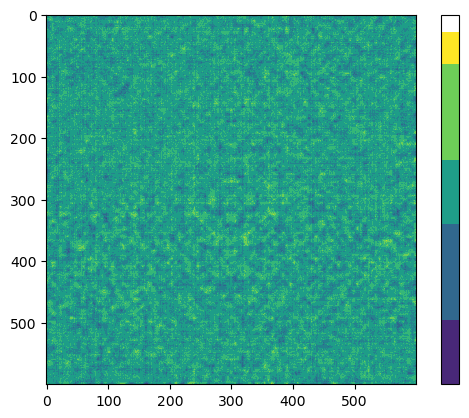

In [139]:
plt.imshow(ds.VP[:,:,0])#.plot()
plt.colorbar()
# #ds.VP[0,0,140:155].plot()

In [140]:
#plt.plot(mesh.element_nodal_fields['VP'][66265:66275,0])

In [141]:
mesh.edges_per_element

12

In [142]:
mesh.element_nodal_fields['RHO'][:,0]#[66265:66275,0]

array([2237.18321013, 2237.18321013, 2237.18321037, ..., 1928.16034469,
       1928.16034469, 1928.16034469])

In [ ]:
mesh.nodes_per_element

In [ ]:
mesh.points.shape

In [ ]:
side_length_el = abs(mesh.points[10000,2]-mesh.points[10001,2])
side_length_el

In [ ]:
# Plot receiver grid in relation to elements
xdim = abs(mesh.points[0,0])+abs(mesh.points[-1,0])
ydim = abs(mesh.points[0,1])+abs(mesh.points[-1,1])
zdim = abs(mesh.points[0,2])+abs(mesh.points[-1,2])
ratio = zdim/xdim

V = xdim*ydim*zdim
#side_length = (V/mesh.nelem)**(1/3)
side_length = abs(mesh.points[0,2]-mesh.points[1,2])

nx_el = xdim/side_length
ny_el = ydim/side_length
nz_el = zdim/side_length
nx_el*ny_el*nz_el


l1 = np.arange(mesh.points[0,0] ,mesh.points[-1,0] ,hmax)
l2 = np.arange(mesh.points[0,1] ,mesh.points[-1,1] ,hmax)
l3 = np.arange(mesh.points[0,2] ,mesh.points[-1,2],side_length)
El_pos = np.array([l1,l2,l3])
ll1,ll2,ll3 = np.meshgrid(l1,l2,l3)

ax,fig = plt.subplots(figsize=(10,10))
#plt.title('Receiver grid relative to elements in X-Y plane', fontsize=16)
# plt.scatter(ll1[42:48,42:48,0],ll2[42:48,42:48,0], label='Element Boundaries',s=50)
#plt.scatter(ll1[85:93,85:93,0],ll2[85:93,85:93,0], label='Element Boundaries',s=50)
#plt.scatter(ll1[43:48,43:48,0],ll2[43:48,43:48,0], label='Element Boundaries',s=50)
plt.scatter(ll1[82:86,82:86,0],ll2[82:86,82:86,0], label='Element Boundaries',s=50)

#plt.scatter(ll1[6:11,6:11,0],ll2[6:11,6:11,0])
plt.scatter(rec_list[0], rec_list[1], label='Receiver Grid x-y plane', marker ='v',s=50)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right',fontsize=14)

In [ ]:
side_length

In [ ]:
El_pos.shape

In [ ]:
El_pos_array = xr.Dataset(
    data_vars={
        "x_el": (["len1"], l1),
        "y_el": (["len2"], l2),
        "z_el": (["len3"], l3),
        
    },
    coords={"len1": np.arange(0,len(l1)),"len2": np.arange(0,len(l2)),"len3": np.arange(0,len(l3))},
)

In [ ]:
El_pos_array.x_el.values

In [ ]:
nz-l3[9::]

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(np.ones(rec_list[2].shape),abs(rec_list[2]-200))
plt.scatter(np.ones(l3[9:23].shape),l3[9:23])
plt.gca().invert_yaxis()

In [ ]:
#gg=vs_sub[posX,posY,::-1]
#gg[53]

In [ ]:
np.linspace(0,199, 200)

In [ ]:
nz-rec_list[2]

In [ ]:
vp_sub = ds_without_q.vp.values
posX=2
posY=2
plt.figure(figsize=(12,10))
plt.plot(ds.VP[0,0,:],nz-ds.z[:], label='True extracted model',linestyle=':', linewidth='3', color='black') #235:246
plt.scatter(vp_sub[posX,posY,::-1],np.linspace(0,nz-1, nz),label='xarray points')# label = r'True $v_{S}$ Model',color='black')#,linestyle=':', linewidth='3')
plt.rcParams.update({'font.size': 16})
#plt.scatter(np.ones(rec_list[2].shape)*1312,nz-(rec_list[2]))

plt.gca().invert_yaxis()
plt.xlabel(r'$v_{s}$ [m/s]')
plt.ylabel(r'Depth [m]')
#plt.ylim([nrz+2,-2])
plt.ylim([60,40])
plt.xlim([np.min(vp_sub)-100,np.max(vp_sub)+100])
plt.scatter(np.ones(El_pos[2].shape)*1250, nz-El_pos[2],  color='r', s=50, label='Element boundaries')
plt.legend(loc='upper right', fontsize =14)

In [ ]:
p

In [ ]:
#reference_frequency=[ w for w in zip(freqs)]
#reference_frequency

In [58]:
# Now actually run the simulations.
for name in ["without_attenuation"]: #["with_attenuation", "without_attenuation"]
    p.simulations.launch(
        simulation_configuration=name,
        events=p.events.list(),
        site_name=SALVUS_FLOW_SITE_NAME,
        ranks_per_job=16,
        #extra_output_configuration={
        #"frequency_domain": {
        #    "fields": ["displacement"],
        #    "frequencies": [12.0],}}
    )
    p.simulations.query(block=True)

[2023-12-05 09:25:47,858] INFO: Submitting job ...
Uploading 1 files...

🚀  Submitted job_2312050925910777_c487ff7b01@local


VBox()

In [ ]:
## IMPORTANT FOR ATTENUATION INVERSION!!!

#p.simulations.launch(
#    ranks_per_job=4,
#    site_name="local",
#    events=p.events.list(),
#    simulation_configuration="simulation",
#    extra_output_configuration={
#        "frequency_domain": {
#            "fields": ["displacement"],
#            "frequencies": [1.0, 2.0, 3.0],
#        }
#    },
#)

## Results


The amplitude of the attenuated waves is of course smaller but they also arrive a tad bit later.

In [ ]:
# p.viz.waveforms(
#     event=event_name,
#     receiver_name="XX.000007",
#     data=["with_attenuation", "without_attenuation"],
#     receiver_field="velocity",
# )
# #plt.show()

In [ ]:
p

In [59]:
WF     = p.waveforms.get('without_attenuation', event_name)
#WF_att = p.waveforms.get('with_attenuation', event_name)

EV     = WF.events[0]
#EV_att = WF_att.events[0]

#EV.sources

In [60]:
stat = EV.receiver_name_list

stat_orig = []
for i in range(len(recs)):
    stat_orig = np.append(stat_orig,str(recs[i].network_code) +'.'+ str(recs[i].station_code+'.')).tolist()
    #print(str(recs[i].network_code) +'.'+ str(recs[i].station_code+'.'))
#stat_orig

#Z_ind = [stat.index(x) for _,x in sorted(zip(stat,stat_orig))]
#Z     = [x for _,x in sorted(zip(stat,stat_orig))]

stat_orig == stat

True

In [61]:
#EV.get_receiver('XX.000011.')
#EV.receiver_name_list[100]
#stat[100]
#plt.plot(EV.get_receiver_data('XX.0000100.', receiver_field='velocity')[0][:]-data_X[100])

In [62]:
#diff_DATout = np.zeros((len(EV.receiver_name_list),nt))
#for i in range(len(EV.receiver_name_list)):
#    #print(EV.get_receiver_data(EV.receiver_name_list[i], receiver_field='velocity')[0])
#    diff_DATout[i] = EV.get_receiver_data(EV.receiver_name_list[i], receiver_field='velocity')[0][:]-data_X[i]

In [63]:
# Sampling times and intervals for 'model_with_Q'

for jj in range(0,len(EV.receivers)):
    p1, p2=EV.receivers[jj], EV.data

nt = p2.npts
dt = 1/p2.sampling_rate_in_hertz

# Storage initialization

Pressure=np.zeros((len(EV.receivers),nt))

velocity_X=np.zeros((len(EV.receivers),nt))
velocity_Y=np.zeros((len(EV.receivers),nt))
velocity_Z=np.zeros((len(EV.receivers),nt))

acceleration_X=np.zeros((len(EV.receivers),nt))
acceleration_Y=np.zeros((len(EV.receivers),nt))
acceleration_Z=np.zeros((len(EV.receivers),nt))

displacement_gradXx = np.zeros((len(EV.receivers),nt))
displacement_gradXy = np.zeros((len(EV.receivers),nt))
displacement_gradXz = np.zeros((len(EV.receivers),nt))
displacement_gradYx = np.zeros((len(EV.receivers),nt))
displacement_gradYy = np.zeros((len(EV.receivers),nt))
displacement_gradYz = np.zeros((len(EV.receivers),nt))
displacement_gradZx = np.zeros((len(EV.receivers),nt))
displacement_gradZy = np.zeros((len(EV.receivers),nt))
displacement_gradZz = np.zeros((len(EV.receivers),nt))

displacement_X=np.zeros((len(EV.receivers),nt))
displacement_Y=np.zeros((len(EV.receivers),nt))
displacement_Z=np.zeros((len(EV.receivers),nt))

In [64]:
#.__getattr__

In [65]:
1/p2.sampling_rate_in_hertz

0.00013683608340735724

In [66]:
p2.npts

23544

In [67]:
EV.receivers

[{'fields': ['phi_t'],
  'location': [261.0, 261.0, 300.0],
  'location_code': '',
  'network_code': 'XX',
  'station_code': '000000'},
 {'fields': ['phi_t'],
  'location': [261.0, 261.0, 299.0],
  'location_code': '',
  'network_code': 'XX',
  'station_code': '000001'},
 {'fields': ['phi_t'],
  'location': [261.0, 261.0, 298.0],
  'location_code': '',
  'network_code': 'XX',
  'station_code': '000002'},
 {'fields': ['phi_t'],
  'location': [261.0, 263.0, 300.0],
  'location_code': '',
  'network_code': 'XX',
  'station_code': '000100'},
 {'fields': ['phi_t'],
  'location': [261.0, 263.0, 299.0],
  'location_code': '',
  'network_code': 'XX',
  'station_code': '000101'},
 {'fields': ['phi_t'],
  'location': [261.0, 263.0, 298.0],
  'location_code': '',
  'network_code': 'XX',
  'station_code': '000102'},
 {'fields': ['phi_t'],
  'location': [261.0, 265.0, 300.0],
  'location_code': '',
  'network_code': 'XX',
  'station_code': '000200'},
 {'fields': ['phi_t'],
  'location': [261.0, 265

In [68]:
# DATA without attenuation
for jj in range(0,len(EV.receivers)):
    pp1, pp2=EV.receivers[jj], EV.data
    press = pp2.get_receiver_data(pp1,'phi_t', 'XX.')[0]
    #pressY = pp2.get_receiver_data(pp1,'phi_t', 'XX.')[1]    
    #pressZ = pp2.get_receiver_data(pp1,'phi_t', 'XX.')[2]

#     streamX = pp2.get_receiver_data(pp1,'velocity', 'XX.')[0]
#     streamY = pp2.get_receiver_data(pp1,'velocity', 'XX.')[1]    
#     streamZ = pp2.get_receiver_data(pp1,'velocity', 'XX.')[2]
    
#     accX = pp2.get_receiver_data(pp1,'acceleration', 'XX.')[0]
#     accY = pp2.get_receiver_data(pp1,'acceleration', 'XX.')[1]    
#     accZ = pp2.get_receiver_data(pp1,'acceleration', 'XX.')[2]
    
#     disp_gradXx = EV.get_receiver_data(EV.receiver_name_list[jj], receiver_field='gradient-of-displacement')[0]
#     disp_gradXy = EV.get_receiver_data(EV.receiver_name_list[jj], receiver_field='gradient-of-displacement')[1]
#     disp_gradXz = EV.get_receiver_data(EV.receiver_name_list[jj], receiver_field='gradient-of-displacement')[2]
#     disp_gradYx = EV.get_receiver_data(EV.receiver_name_list[jj], receiver_field='gradient-of-displacement')[3]
#     disp_gradYy = EV.get_receiver_data(EV.receiver_name_list[jj], receiver_field='gradient-of-displacement')[4]
#     disp_gradYz = EV.get_receiver_data(EV.receiver_name_list[jj], receiver_field='gradient-of-displacement')[5]
#     disp_gradZx = EV.get_receiver_data(EV.receiver_name_list[jj], receiver_field='gradient-of-displacement')[6]
#     disp_gradZy = EV.get_receiver_data(EV.receiver_name_list[jj], receiver_field='gradient-of-displacement')[7]
#     disp_gradZz = EV.get_receiver_data(EV.receiver_name_list[jj], receiver_field='gradient-of-displacement')[8]
    
#     dispX = pp2.get_receiver_data(pp1,'displacement', 'XX.')[0]
#     dispY = pp2.get_receiver_data(pp1,'displacement', 'XX.')[1]    
#     dispZ = pp2.get_receiver_data(pp1,'displacement', 'XX.')[2]

    Pressure[jj,:] = press
#     p_Y[jj,:] = pressY
#     p_Z[jj,:] = pressZ

#     velocity_X[jj,:] = streamX
#     velocity_Y[jj,:] = streamY
#     velocity_Z[jj,:] = streamZ
    
#     acceleration_X[jj,:] = accX
#     acceleration_Y[jj,:] = accY
#     acceleration_Z[jj,:] = accZ
    
#     displacement_X[jj,:] = dispX
#     displacement_Y[jj,:] = dispY
#     displacement_Z[jj,:] = dispZ
    
#     displacement_gradXx[jj,:] = disp_gradXx
#     displacement_gradXy[jj,:] = disp_gradXy
#     displacement_gradXz[jj,:] = disp_gradXz
#     displacement_gradYx[jj,:] = disp_gradYx
#     displacement_gradYy[jj,:] = disp_gradYy
#     displacement_gradYz[jj,:] = disp_gradYz
#     displacement_gradZx[jj,:] = disp_gradZx
#     displacement_gradZy[jj,:] = disp_gradZy
#     displacement_gradZz[jj,:] = disp_gradZz
    

#data_X = data_X[Z_ind]
#data_Y = data_Y[Z_ind]
#data_Z = data_Z[Z_ind]

In [69]:
# Save data for 'model_without_Q'

output_fields = xr.Dataset(
    data_vars={
#         "velocity_x": (["station_n", "time"], velocity_X),
#         "velocity_y": (["station_n", "time"], velocity_Y),
#         "velocity_z": (["station_n", "time"], velocity_Z),
#         "displacement_x": (["station_n", "time"], displacement_X),
#         "displacement_y": (["station_n", "time"], displacement_Y),
#         "displacement_z": (["station_n", "time"], displacement_Z),
#         "acceleration_x": (["station_n", "time"], acceleration_X),
#         "acceleration_y": (["station_n", "time"], acceleration_Y),
#         "acceleration_z": (["station_n", "time"], acceleration_Z),
#         "displacement_gradXx": (["station_n", "time"], displacement_gradXx),
#         "displacement_gradXy": (["station_n", "time"], displacement_gradXy),
#         "displacement_gradXz": (["station_n", "time"], displacement_gradXz),
#         "displacement_gradYx": (["station_n", "time"], displacement_gradYx),
#         "displacement_gradYy": (["station_n", "time"], displacement_gradYy),
#         "displacement_gradYz": (["station_n", "time"], displacement_gradYz),
#          "displacement_gradZx": (["station_n", "time"], displacement_gradZx),
#         "displacement_gradZy": (["station_n", "time"], displacement_gradZy),
#         "displacement_gradZz": (["station_n", "time"], displacement_gradZz),
        "Pressure": (["station_n", "time"], Pressure),
        
    },
    coords={"station_n": stat, "time": np.arange(0,nt)},
)

output_fields.to_netcdf(output_+"/output.nc", engine="h5netcdf", mode='a')

In [ ]:
# Sampling times and intervals for 'model_with_Q'

for jj in range(0,len(EV_att.receivers)):
    p1_att, p2_att=EV_att.receivers[jj], EV_att.data

nt_att = p2_att.npts
dt_att = 1/p2_att.sampling_rate_in_hertz


# Storage initialization

velocity_X_att=np.zeros((len(EV_att.receivers),nt_att))
velocity_Y_att=np.zeros((len(EV_att.receivers),nt_att))
velocity_Z_att=np.zeros((len(EV_att.receivers),nt_att))

acceleration_X_att=np.zeros((len(EV_att.receivers),nt_att))
acceleration_Y_att=np.zeros((len(EV_att.receivers),nt_att))
acceleration_Z_att=np.zeros((len(EV_att.receivers),nt_att))

displacement_gradXx_att = np.zeros((len(EV_att.receivers),nt_att))
displacement_gradXy_att = np.zeros((len(EV_att.receivers),nt_att))
displacement_gradXz_att = np.zeros((len(EV_att.receivers),nt_att))
displacement_gradYx_att = np.zeros((len(EV_att.receivers),nt_att))
displacement_gradYy_att = np.zeros((len(EV_att.receivers),nt_att))
displacement_gradYz_att = np.zeros((len(EV_att.receivers),nt_att))
displacement_gradZx_att = np.zeros((len(EV_att.receivers),nt_att))
displacement_gradZy_att = np.zeros((len(EV_att.receivers),nt_att))
displacement_gradZz_att = np.zeros((len(EV_att.receivers),nt_att))

displacement_X_att=np.zeros((len(EV_att.receivers),nt_att))
displacement_Y_att=np.zeros((len(EV_att.receivers),nt_att))
displacement_Z_att=np.zeros((len(EV_att.receivers),nt_att))

In [ ]:
# Fill DATA with attenuation

for jj in range(0,len(EV_att.receivers)):
    pp1_att, pp2_att=EV_att.receivers[jj], EV_att.data
    streamX_att = pp2_att.get_receiver_data(pp1_att,'velocity', 'XX.')[0]
    streamY_att = pp2_att.get_receiver_data(pp1_att,'velocity', 'XX.')[1]    
    streamZ_att = pp2_att.get_receiver_data(pp1_att,'velocity', 'XX.')[2]
    
    accX_att = pp2_att.get_receiver_data(pp1_att,'acceleration', 'XX.')[0]
    accY_att = pp2_att.get_receiver_data(pp1_att,'acceleration', 'XX.')[1]    
    accZ_att = pp2_att.get_receiver_data(pp1_att,'acceleration', 'XX.')[2]
    
    disp_gradXx_att = EV_att.get_receiver_data(EV_att.receiver_name_list[jj], receiver_field='gradient-of-displacement')[0]
    disp_gradXy_att = EV_att.get_receiver_data(EV_att.receiver_name_list[jj], receiver_field='gradient-of-displacement')[1]
    disp_gradXz_att = EV_att.get_receiver_data(EV_att.receiver_name_list[jj], receiver_field='gradient-of-displacement')[2]
    disp_gradYx_att = EV_att.get_receiver_data(EV_att.receiver_name_list[jj], receiver_field='gradient-of-displacement')[3]
    disp_gradYy_att = EV_att.get_receiver_data(EV_att.receiver_name_list[jj], receiver_field='gradient-of-displacement')[4]
    disp_gradYz_att = EV_att.get_receiver_data(EV_att.receiver_name_list[jj], receiver_field='gradient-of-displacement')[5]
    disp_gradZx_att = EV_att.get_receiver_data(EV_att.receiver_name_list[jj], receiver_field='gradient-of-displacement')[6]
    disp_gradZy_att = EV_att.get_receiver_data(EV_att.receiver_name_list[jj], receiver_field='gradient-of-displacement')[7]
    disp_gradZz_att = EV_att.get_receiver_data(EV_att.receiver_name_list[jj], receiver_field='gradient-of-displacement')[8]
    
    dispX_att = pp2_att.get_receiver_data(pp1_att,'displacement', 'XX.')[0]
    dispY_att = pp2_att.get_receiver_data(pp1_att,'displacement', 'XX.')[1]    
    dispZ_att = pp2_att.get_receiver_data(pp1_att,'displacement', 'XX.')[2]

    velocity_X_att[jj,:] = streamX_att
    velocity_Y_att[jj,:] = streamY_att
    velocity_Z_att[jj,:] = streamZ_att
    
    acceleration_X_att[jj,:] = accX_att
    acceleration_Y_att[jj,:] = accY_att
    acceleration_Z_att[jj,:] = accZ_att
    
    displacement_X_att[jj,:] = dispX_att
    displacement_Y_att[jj,:] = dispY_att
    displacement_Z_att[jj,:] = dispZ_att
    
    displacement_gradXx_att[jj,:] = disp_gradXx_att
    displacement_gradXy_att[jj,:] = disp_gradXy_att
    displacement_gradXz_att[jj,:] = disp_gradXz_att
    displacement_gradYx_att[jj,:] = disp_gradYx_att
    displacement_gradYy_att[jj,:] = disp_gradYy_att
    displacement_gradYz_att[jj,:] = disp_gradYz_att
    displacement_gradZx_att[jj,:] = disp_gradZx_att
    displacement_gradZy_att[jj,:] = disp_gradZy_att
    displacement_gradZz_att[jj,:] = disp_gradZz_att

In [ ]:
# Save data for 'model_with_Q'

output_fields_ATT = xr.Dataset(
    data_vars={
        "velocity_x": (["station_n", "time"], velocity_X_att),
        "velocity_y": (["station_n", "time"], velocity_Y_att),
        "velocity_z": (["station_n", "time"], velocity_Z_att),
        "displacement_x": (["station_n", "time"], displacement_X_att),
        "displacement_y": (["station_n", "time"], displacement_Y_att),
        "displacement_z": (["station_n", "time"], displacement_Z_att),
        "acceleration_x": (["station_n", "time"], acceleration_X_att),
        "acceleration_y": (["station_n", "time"], acceleration_Y_att),
        "acceleration_z": (["station_n", "time"], acceleration_Z_att),
        "displacement_gradXx": (["station_n", "time"], displacement_gradXx_att),
        "displacement_gradXy": (["station_n", "time"], displacement_gradXy_att),
        "displacement_gradXz": (["station_n", "time"], displacement_gradXz_att),
        "displacement_gradYx": (["station_n", "time"], displacement_gradYx_att),
        "displacement_gradYy": (["station_n", "time"], displacement_gradYy_att),
        "displacement_gradYz": (["station_n", "time"], displacement_gradYz_att),
         "displacement_gradZx": (["station_n", "time"], displacement_gradZx_att),
        "displacement_gradZy": (["station_n", "time"], displacement_gradZy_att),
        "displacement_gradZz": (["station_n", "time"], displacement_gradZz_att),
        
    },
    coords={"station_n": stat, "time": np.arange(0,nt_att)},
)

output_fields_ATT.to_netcdf(output_+"/output_ATT.nc", engine="h5netcdf", mode='a')

In [70]:
par = {  'vel_model': vel_model_type, 
         'rho_model': rho_model_type,
         'Q_model': Q_model, 
         'x_domain': nx,
         'y_domain': ny,
         'z_domain': nz,
         'h_max': hmax,
         'source_type': source_type,
         'elements_per_wavelength': elements_per_wavelength,
         'simulation_time': sim_time,
         'start_time': p2.start_time_in_seconds,
         #'bc':BC,
         'dist_X': dist_X,
         'dist_Y': dist_Y,
         'dist_Z': dist_Z,
         'nt': nt,
         #'nt_att': nt_att,
         'dt': dt,
         'dt_at': dt,
         'recs_surf': n_surf,
         'recs_depth': nrz,
         'recs_total': N_tot,
         'rec_grid_pos': [rx0,ry0,rx1,ry1,rz0,rz1], 
         'src_loc' : [sx,sy,sz],
         'src_cent_f': center_frequency,
      }
json.dump( par, open( para_+"/_ALL.json", 'w' ) )

# Read data from file:
#data = json.load( open( "file_name.json" ) )

In [71]:
# Store Simulation parameters and input fields

# Velocity, rho, Q models
#ds_with_q.to_netcdf(str(input_)+"/ds_with_q.nc", engine="h5netcdf", mode='a')
ds_without_q.to_netcdf(str(input_)+"/ds_without_q.nc", engine="h5netcdf", mode='a')

# Receiver field (name and position)
receiver_field.to_netcdf(str(input_)+"/recs.nc", engine="h5netcdf", mode='a')
#El_pos_array.to_netcdf(str(input_)+"/el_pos.nc", engine="h5netcdf", mode='a')
# Source 
#json.dump( src, open( input_+"/_src.json", 'w' ) )

In [ ]:
ds_without_q.to_netcdf(str(input_)+"/ds_without_q.nc", engine="h5netcdf", mode='a')

In [ ]:
Pressure.shape

In [ ]:
#p.viz.shotgather(ds_with_q.vp, 'src_loc_a', 'velocity','z', 'with_attenuation')

In [ ]:
#p.viz.shotgather